In [1]:
import sys
sys.path.append('../code')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
test_object = np.load('../data/potato96_1000.npz', allow_pickle=True)["test_objects"][0]

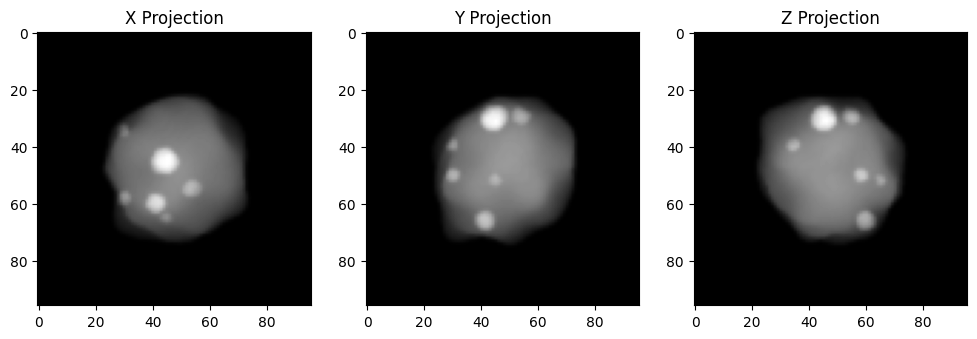

In [4]:
#Visualize X, Y , Z projection of the object
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_object.sum(axis=0), cmap='gray')
ax[0].set_title('X Projection')
ax[1].imshow(test_object.sum(axis=1), cmap='gray')
ax[1].set_title('Y Projection')
ax[2].imshow(test_object.sum(axis=2), cmap='gray')
ax[2].set_title('Z Projection')
plt.show()

In [5]:
shape = test_object.shape
print(shape)

(96, 96, 96)


In [6]:
import Reconstruction_pytorch as RP
import RotationParams as RPm


In [7]:
model = RP.TomoReconstructionModel(shape[0])

c:\Users\fredr\miniconda3\envs\torchenv\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
Rot_accum, rot_parameters, Q_accum = RPm.CreateRotationParams(n_phi = 300, compute_Q_accum = True)


In [1]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
test_object_tensor = torch.tensor(test_object, dtype=torch.float32).to(device)
quaternions_tensor = torch.tensor(Q_accum[0], dtype=torch.float32).to(device)

NameError: name 'torch' is not defined

In [10]:
projections_tensor = model.full_projection(test_object_tensor, quaternions_tensor)

In [11]:
projections_tensor.shape

torch.Size([300, 96, 96])

In [12]:
import torch.nn as nn

# Define loss function (e.g., Mean Squared Error)
criterion = nn.L1Loss()

# Define optimizer (e.g., Adam optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=8e-3)

In [13]:
#Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


TomoReconstructionModel()

In [14]:
#Add a dimension to the projections tensor
projections_tensor = projections_tensor.unsqueeze(1)

In [15]:
num_epochs = 200
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass: Compute estimated projections
    estimated_projections = model(projections_tensor, quaternions_tensor)
    
    # Compute loss
    loss = criterion(estimated_projections, projections_tensor)
    
    # Backward pass: Compute gradients
    loss.backward()
    
    # Update model parameters
    optimizer.step()
    
    # Print loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    losses.append(loss.item())

Epoch [1/200], Loss: 8.4454
Epoch [2/200], Loss: 8.7021
Epoch [3/200], Loss: 8.4056
Epoch [4/200], Loss: 8.3764
Epoch [5/200], Loss: 8.3240
Epoch [6/200], Loss: 8.1477
Epoch [7/200], Loss: 7.9831
Epoch [8/200], Loss: 7.9757
Epoch [9/200], Loss: 7.8941
Epoch [10/200], Loss: 7.7552
Epoch [11/200], Loss: 7.6699
Epoch [12/200], Loss: 7.6140
Epoch [13/200], Loss: 7.5036
Epoch [14/200], Loss: 7.3973
Epoch [15/200], Loss: 7.3416
Epoch [16/200], Loss: 7.2700
Epoch [17/200], Loss: 7.1633
Epoch [18/200], Loss: 7.0691
Epoch [19/200], Loss: 7.0123
Epoch [20/200], Loss: 6.9240
Epoch [21/200], Loss: 6.8329
Epoch [22/200], Loss: 6.7685
Epoch [23/200], Loss: 6.6821
Epoch [24/200], Loss: 6.5961
Epoch [25/200], Loss: 6.5309
Epoch [26/200], Loss: 6.4444
Epoch [27/200], Loss: 6.3701
Epoch [28/200], Loss: 6.2967
Epoch [29/200], Loss: 6.2120
Epoch [30/200], Loss: 6.1464
Epoch [31/200], Loss: 6.0643
Epoch [32/200], Loss: 5.9927
Epoch [33/200], Loss: 5.9167
Epoch [34/200], Loss: 5.8449
Epoch [35/200], Loss: 5

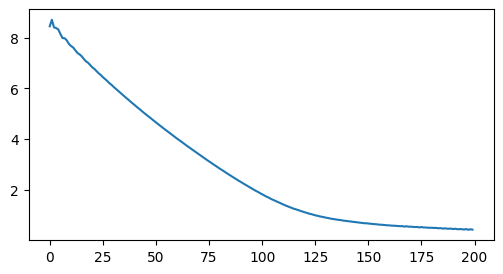

In [16]:
plt.figure(figsize = (6,3))
plt.plot(losses)

In [17]:
#Get projections from the model
projections_tensor_pred = model.full_projection(model.volume, quaternions_tensor)

In [18]:
projections_tensor_pred = projections_tensor_pred.unsqueeze(1)

Text(0.5, 1.0, 'Difference')

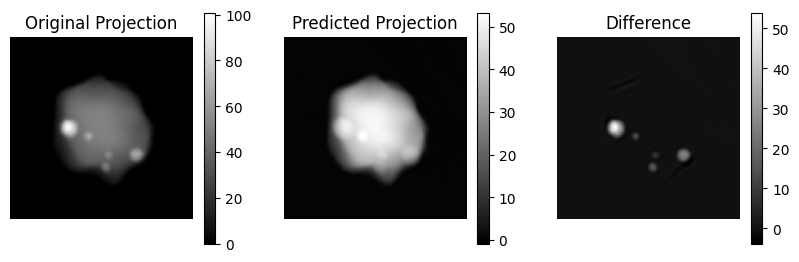

In [19]:
#Compare the original projections with the predicted projections
for _ in range(3):
    r_idx = np.random.randint(0, projections_tensor.shape[0])
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(projections_tensor[r_idx, 0].cpu().detach().numpy(), cmap='gray')
    plt.colorbar()
    plt.axis('off')
    plt.title('Original Projection')
    plt.subplot(1, 3, 2)
    plt.imshow(projections_tensor_pred[r_idx, 0].cpu().detach().numpy(), cmap='gray')
    plt.colorbar()
    plt.axis('off')
    plt.title('Predicted Projection')
    plt.subplot(1, 3, 3)
    plt.imshow(projections_tensor[r_idx, 0].cpu().detach().numpy() - projections_tensor_pred[r_idx, 0].cpu().detach().numpy(), cmap='gray')
    plt.colorbar()
    plt.axis('off')
    plt.title('Difference')

### Try with noisy quaternions

In [31]:
#Remove uneccessary things from gpu
del model
del projections_tensor_pred

In [32]:
model = RP.TomoReconstructionModel(shape[0])

In [33]:
#Add random noise to the quaternions
quaternions_tensor_noisy = quaternions_tensor + 0.1 * torch.randn_like(quaternions_tensor)
#Normalize the noisy quaternions so that they have unit norm
quaternions_tensor_noisy = quaternions_tensor_noisy / torch.norm(quaternions_tensor_noisy, dim=1, keepdim=True)

In [34]:
#Move model and quaternions to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
quaternions_tensor_noisy.to(device)

tensor([[ 0.9930, -0.1006, -0.0017,  0.0623],
        [ 0.9909, -0.0882, -0.0199, -0.1001],
        [ 0.9914, -0.1038,  0.0200, -0.0770],
        ...,
        [ 0.5058, -0.3450,  0.7365, -0.2876],
        [ 0.6887, -0.3126,  0.5853, -0.2922],
        [ 0.6900, -0.1340,  0.5922, -0.3940]], device='cuda:0')

In [35]:
# Define optimizer (e.g., Adam optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=8e-3)

In [36]:

#Train the model with noisy quaternions
num_epochs = 200
lossesv2 = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass: Compute estimated projections
    estimated_projections = model(projections_tensor, quaternions_tensor_noisy)
    
    # Compute loss
    loss = criterion(estimated_projections, projections_tensor)
    
    # Backward pass: Compute gradients
    loss.backward()
    
    # Update model parameters
    optimizer.step()
    
    # Print loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    lossesv2.append(loss.item())
    

Epoch [1/200], Loss: 8.4454
Epoch [2/200], Loss: 8.7174


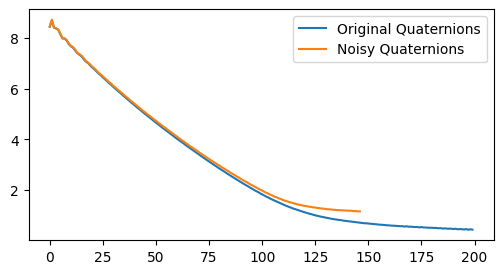

In [ ]:
plt.figure(figsize = (6,3))
plt.plot(losses, label='Original Quaternions')
plt.plot(lossesv2, label='Noisy Quaternions')
plt.legend()

In [ ]:
#Get projections from the model
projections_tensor_pred = model.full_projection(model.volume, quaternions_tensor)

In [ ]:
projections_tensor_pred = projections_tensor_pred.unsqueeze(1)

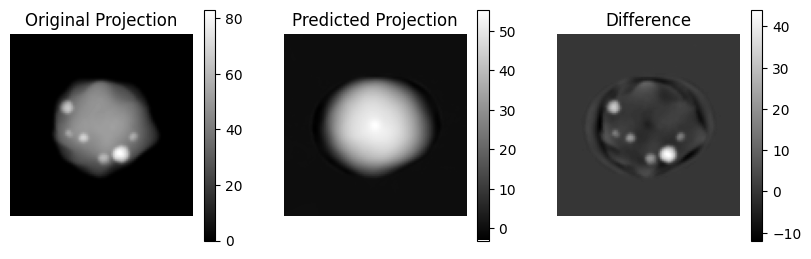

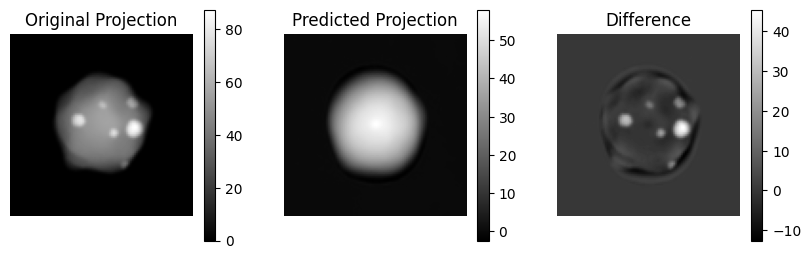

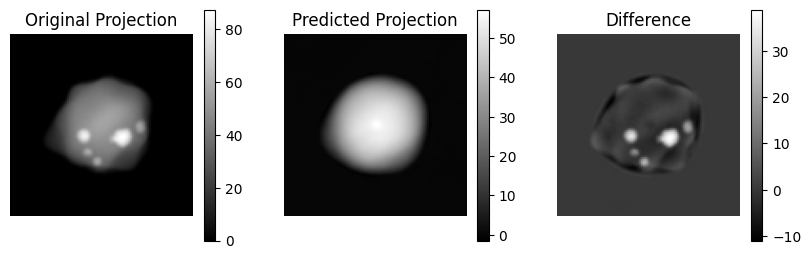

In [ ]:
#Compare the original projections with the predicted projections
for _ in range(3):
    r_idx = np.random.randint(0, projections_tensor.shape[0])
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(projections_tensor[r_idx, 0].cpu().detach().numpy(), cmap='gray')
    plt.colorbar()
    plt.axis('off')
    plt.title('Original Projection')
    plt.subplot(1, 3, 2)
    plt.imshow(projections_tensor_pred[r_idx, 0].cpu().detach().numpy(), cmap='gray')
    plt.colorbar()
    plt.axis('off')
    plt.title('Predicted Projection')
    plt.subplot(1, 3, 3)
    plt.imshow(projections_tensor[r_idx, 0].cpu().detach().numpy() - projections_tensor_pred[r_idx, 0].cpu().detach().numpy(), cmap='gray')
    plt.colorbar()
    plt.axis('off')
    plt.title('Difference')